In [ ]:
"""
CONNECT WITH DRIVE
"""

%pip install gdown
import gdown
import os
import shutil
from google.colab import drive

# Drive
drive.mount('/content/drive')

# url = 'https://drive.google.com/uc?id=1AvXhv8p9ZCUZ2dzbYoA5CP8VT7a8b6Gf' # full
url = 'https://drive.google.com/uc?id=1xGGw7IbS_o_ClyyhJUdpiaOyJ-YNuxSQ' # train
url_test = 'https://drive.google.com/uc?id=1avXqQoy43M9zGoxHWy4C25cPGQzgeEMn' # test

output = 'dataset_nonrandom_responses.pth'

gdown.download(url, output, quiet=False)
gdown.download(url_test, f'{output}_test', quiet=False)

# Github
!git clone https://github.com/karolrogozinski/cern_alice_fast_sim_corrvae.git

source = '/content/cern_alice_fast_sim_corrvae'
destination = '/content'

for file in os.listdir(source):
    source_path = os.path.join(source, file)
    dest_path = os.path.join(destination, file)

    try:
        shutil.copy(source_path, dest_path)
    except IsADirectoryError:
        shutil.copytree(source_path, dest_path)


Mounted at /content/drive
Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1xGGw7IbS_o_ClyyhJUdpiaOyJ-YNuxSQ 



Access denied with the following error:
Cloning into 'cern_alice_fast_sim_corrvae'...



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1avXqQoy43M9zGoxHWy4C25cPGQzgeEMn 



remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 183 (delta 74), reused 43 (delta 20), pack-reused 63
Receiving objects: 100% (183/183), 196.54 KiB | 19.65 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [ ]:
"""
CorrVAE training based on [TODO]
"""

import time

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

import tensorflow as tf

from src.model import ControlVAE
from src.encoders import EncoderControlVAE
from src.decoders import DecoderControlVAE
from src.optim import Optimization

from utils.helpers import plot_epoch, save_model, sum_channels_parallel
from utils.loss import get_losses


In [ ]:
"""
PROPERTIES
All of them are normalized

0. - x coordinate of max pixel
1. - y coordinate of max pixel
2. - x coordinate of mass center
3. - y coordinate of mass center
4. - number of non zero pixels
5. - categorized number of non zero pixels
6. - sum of pixels, over the treshold
7. - sum of pixels
8. - max pixel value
"""

properties = [2, 3]
properties_cond = [7, 8]


In [ ]:
"""
ARGUMENTS
"""

device = 'cpu'

results_dir = '/content/drive/MyDrive/models/'
data_source = 'dataset_nonrandom_responses.pth'

img_size = (1, 44, 44)
latent_dim = 8
latent_dim_prop = 8
latent_dim_cond = 8
cond_dim = 9

hid_channels = 64

num_prop = len(properties)
num_prop_cond = len(properties_cond)

lr = 5e-4

batch_size = 64
epochs = 250

beta = 1
taus = 0.2
idx_kl = 0
w_kl = 100

lambdas = [
    1000000,    # reconstruction_loss
    1,          # pairwise_tc_loss
    5000000,    # reconstruction_prop_loss
    1,          # kl_loss
    1,          # groupwise_wz_loss
    1,          # groupsize_wc_loss
    1000000,    # reconstruction_prop_cond_loss
    1,          # groupwise_cz_loss
]


In [ ]:
"""
DATA
"""
data_source = '/content/drive/MyDrive/data/dataset_nonrandom_responses_train.pth'


data = torch.load(data_source)
dataset = TensorDataset(data['features'], data['labels'])

train_loader = DataLoader(dataset, shuffle=True, batch_size=1)


data_test = '/content/drive/MyDrive/data/dataset_nonrandom_responses_test.pth'


data_test = torch.load(data_test)
dataset_test = TensorDataset(data_test['features'], data_test['labels'])

test_loader = DataLoader(dataset_test, batch_size=batch_size)


In [ ]:
"""
MODEL
"""

encoder = eval("EncoderControlVAE")
decoder = eval("DecoderControlVAE")

model = ControlVAE(img_size, encoder, decoder, latent_dim, latent_dim_prop,
                   latent_dim_cond, cond_dim, num_prop, num_prop_cond, device=device)
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=lr)

lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[50, 100, 150, 200],
        gamma=0.1
)

mse_loss = torch.nn.MSELoss(reduction="sum")

recon_loss_prop_rec = []
recon_loss_rec = []
kl_loss_rec = []
pwwi_loss_rec = []
pwz_loss_rec = []
l1_loss_rec = []
mask_rec = []


In [ ]:
model_corrvae = model
model_corrvae.load_state_dict(torch.load("/content/modelCorrVAE_99_8_8_8.pt", map_location=torch.device('cpu'))['model_state_dict'])
model_corrvae.eval()


ControlVAE(
  (encoder): EncoderControlVAE(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=512, bias=True)
    (mu_logvar_gen): Linear(in_features=512, out_features=32, bias=True)
    (lin1_cond): Linear(in_features=9, out_features=512, bias=True)
    (lin2_cond): Linear(in_features=512, out_features=512, bias=True)
    (mu_logvar_gen_cond): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): DecoderControlVAE(
    (property_lin_list): ModuleList(
      (0-1): 2 x Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=16, out_features=1, bias=True)
        (3): Sigmoid()
      )

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

cond = data_test['labels'][:, 9:]

xgbr = XGBRegressor()
xgbr.load_model('xgboost_model.json')
prop_pred = xgbr.predict(cond.detach())


In [ ]:
vae_janek = tf.keras.models.load_model("/content/generator_VAE.h5")
gan_janek = tf.keras.models.load_model("/content/generator_GAN")
gan_reg_janek = tf.keras.models.load_model("/content/generator_GAN_aux_reg")


In [ ]:
mask = torch.tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])


In [ ]:
batch_size = data['labels'].shape[0]

model_corrvae.eval()
muloptim = Optimization(dim_w = 8, model = model_corrvae, num_prop = 2, batch_size=batch_size)

optimizer = optim.SGD(muloptim.parameters(), lr=10e-1)
lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[3000, 8000, 15000, 30000, 40000, 70000, 90000],
        gamma=0.1)

prop = data['labels'][:, [2, 3]]
# prop = torch.tensor(prop_pred).detach()

loss_recon = []

epochs = 100
start = time.time()
for epoch in range(epochs):
    prop_pred, loss_value1, w_train, prop_pred, wp = muloptim(prop, mask)

    loss = loss_value1 * 1000000

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print("epoch: ", epoch, "loss: ", loss / 1000000, "time: ", time.time() - start)

    lr_scheduler.step()


epoch:  99 loss:  tensor(6.7092e-08, grad_fn=<DivBackward0>) time:  3.237872838973999


In [ ]:
cond = data['labels'][:, 9:]

dataset_prop = TensorDataset(cond, w_train)
prop_loader_train = DataLoader(dataset_prop, batch_size=128)


In [ ]:
X = data['features']
org=np.exp(X)-1
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

results = np.array([])

for c_, latent_w in tqdm(prop_loader_train):
  latent_z = torch.randn(c_.shape[0], 8).to(device)

  latent_dist_c_mean, latent_dist_c_std  = model_corrvae.encoder.translate_cond(c_)
  latent_c = model_corrvae.reparameterize(
          latent_dist_c_mean, latent_dist_c_std
      )

  result, _, _, _ = model_corrvae.decoder(latent_z, latent_w, latent_c, mask)

  if not results.any():
    results = result.detach().numpy()
  else:
    results = np.concatenate([results, result.detach().numpy()])

results = np.exp(results)-1
results = results.reshape(-1,44,44)


100%|██████████| 1850/1850 [13:13<00:00,  2.33it/s]


In [ ]:
X_ = np.exp(X)-1

eps = 0.96
scale = eps * (X_.mean() / results.mean())


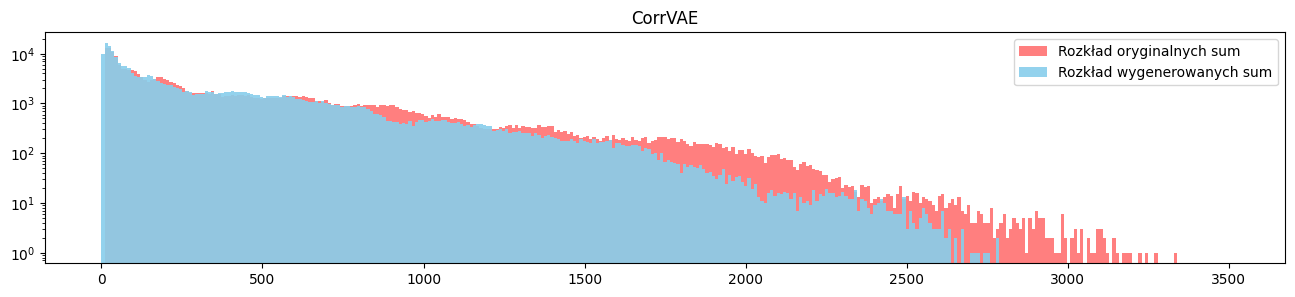

In [ ]:
import matplotlib.pyplot as plt


results_1_ = np.sum(results.reshape([-1, 44, 44]), axis=(1, 2)).flatten()
org_1_ = np.sum(X_.reshape([-1, 44, 44]).numpy(), axis=(1, 2)).flatten()

bins = np.linspace(0, 3500, 350)

# results = results*scale

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_1_, bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CorrVAE')
plt.show()


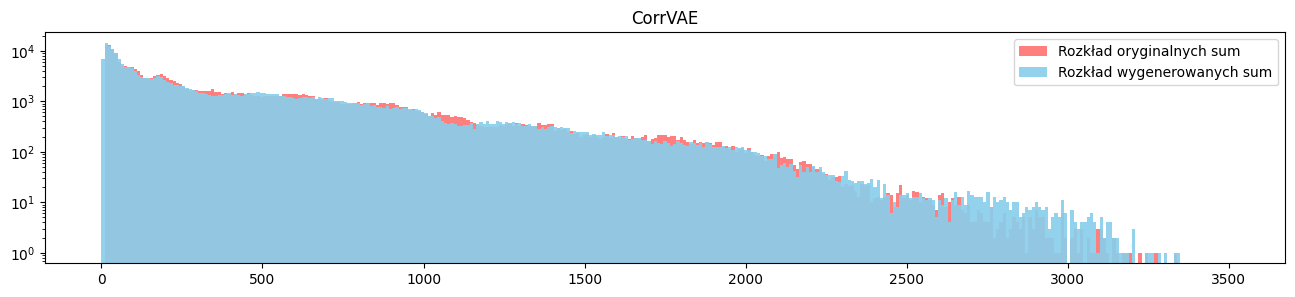

In [ ]:
results_1_ = np.sum(results.reshape([-1, 44, 44]), axis=(1, 2)).flatten() * eps * float(scale)
org_1_ = np.sum(X_.reshape([-1, 44, 44]).numpy(), axis=(1, 2)).flatten()

bins = np.linspace(0, 3500, 350)

# results = results*scale

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_1_, bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CorrVAE')
plt.show()


In [ ]:
batch_size = data_test['labels'].shape[0]

model_corrvae.eval()
muloptim = Optimization(dim_w=8, model=model_corrvae, num_prop=2, batch_size=batch_size)

optimizer = optim.SGD(muloptim.parameters(), lr=2e-1)
lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[3000, 8000, 15000, 30000, 40000, 70000, 90000],
        gamma=0.1)

# prop = data_test['labels'][:, [2, 3]]
prop = torch.tensor(prop_pred).detach()

loss_recon = []

epochs = 100
start = time.time()
for epoch in range(epochs):
    lr_scheduler.step()

    prop_pred, loss_value1, w, prop_pred, wp = muloptim(prop, mask)

    loss = loss_value1 * 1000000

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print("epoch: ", epoch, "loss: ", loss / 1000000, "time: ", time.time() - start)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch:  99 loss:  tensor(5.0738e-08, grad_fn=<DivBackward0>) time:  1.251915693283081


In [ ]:
cond = data_test['labels'][:, 9:]

dataset_prop = TensorDataset(cond, w)
prop_loader = DataLoader(dataset_prop, batch_size=128)


1/1 [==============================] - 0s 22ms/step


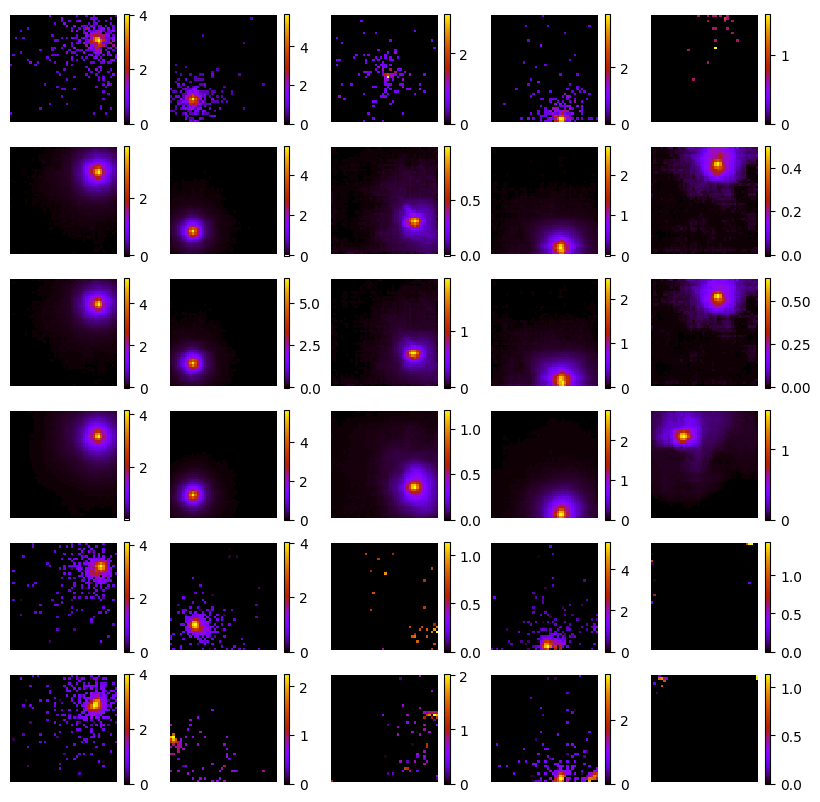

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(6, 5, figsize=(10, 10))

for i in range(15, 20):
    ## Original
    im = axs[0, i%5].imshow(data_test['features'][i][0], interpolation='none', cmap='gnuplot')
    axs[0, i%5].axis('off')
    fig.colorbar(im, ax=axs[0,i%5])

    ## CorrVAE
    tmp_z = torch.randn(1, 8).to(device)

    latent_dist_c_mean, latent_dist_c_std = model_corrvae.encoder.translate_cond(cond[i])
    tmp_c = model_corrvae.reparameterize(
              latent_dist_c_mean, latent_dist_c_std
          )
    x, _, _, _ = model_corrvae.decoder(tmp_z, w[i].unsqueeze(0), tmp_c, mask)
    im = axs[1, i%5].imshow(x[0][0].detach().numpy(), interpolation='none', cmap='gnuplot')
    axs[1, i%5].axis('off')
    fig.colorbar(im, ax=axs[1, i%5])

    ## CorrVAE + post
    tmp_z = torch.randn(1, 8).to(device)

    latent_dist_c_mean, latent_dist_c_std = model_corrvae.encoder.translate_cond(cond[i])
    tmp_c = model_corrvae.reparameterize(
              latent_dist_c_mean, latent_dist_c_std
          )
    x, _, _, _ = model_corrvae.decoder(tmp_z, w[i].unsqueeze(0), tmp_c, mask)
    im = axs[2, i%5].imshow(x[0][0].detach().numpy() * scale, interpolation='none', cmap='gnuplot')
    axs[2, i%5].axis('off')
    fig.colorbar(im, ax=axs[2, i%5])

    ## VAE
    z = np.random.normal(0, 1, (1, 10))
    z_c = cond[i].unsqueeze(0).numpy()
    x = vae_janek.predict([[z], z_c])

    im = axs[3, i%5].imshow(x[0], interpolation='none', cmap='gnuplot')
    axs[3, i%5].axis('off')
    fig.colorbar(im, ax=axs[3, i%5])

    ## GAN
    z = np.random.normal(0, 1, (1, 10))
    z_c = cond[i].unsqueeze(0).numpy()
    x = gan_janek.predict([[z], z_c])

    im = axs[4, i%5].imshow(x[0], interpolation='none', cmap='gnuplot')
    axs[4, i%5].axis('off')
    fig.colorbar(im, ax=axs[4, i%5])

    ## GAN + aux_reg
    z = np.random.normal(0, 3, (1, 10))
    z_c = cond[i].unsqueeze(0).numpy()
    x = gan_reg_janek.predict([[z], z_c])

    im = axs[5, i%5].imshow(x[0] * 0.96, interpolation='none', cmap='gnuplot')
    axs[5, i%5].axis('off')
    fig.colorbar(im, ax=axs[5, i%5])


In [ ]:
from scipy.stats import wasserstein_distance
import pandas as pd

X_test = data_test['features']
org=np.exp(X_test)-1
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org


def calculate_ws_ch_corrvae(n_calc, scale=1):
  ws= [0,0,0,0,0]
  for j in range(n_calc):
    results = np.array([])

    for c_, latent_w in tqdm(prop_loader):
      latent_z = torch.randn(c_.shape[0], 8).to(device)

      latent_dist_c_mean, latent_dist_c_std  = model_corrvae.encoder.translate_cond(c_)
      latent_c = model_corrvae.reparameterize(
              latent_dist_c_mean, latent_dist_c_std
          )

      result, _, _, _ = model_corrvae.decoder(latent_z, latent_w, latent_c, mask)

      if not results.any():
        results = result.detach().numpy()
      else:
        results = np.concatenate([results, result.detach().numpy()])

    results = np.exp(results)-1

    try:
      ch_gen = results.reshape(-1,44,44) * scale
      ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
      for i in range(5):
        ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
      ws =np.array(ws)
    except ValueError as e:
      print(e)

  ws = ws/n_calc
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")

  return results


In [ ]:
def calculate_ws_ch(generator, n_calc, scale=1, noise_std=1):

  ws= [0,0,0,0,0]
  for j in range(n_calc):
    z = np.random.normal(0, noise_std, (data_test['labels'].numpy().shape[0], 10))
    z_c = data_test['labels'][:, 9:].numpy()
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results *scale

    ch_gen = np.array(results).reshape(-1,44,44)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    for i in range(5):
      ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
    ws =np.array(ws)

  ws = ws/n_calc
  print("\n","-"*30,"\n")
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")

  return results


In [ ]:
results_1 = calculate_ws_ch_corrvae(3)


100%|██████████| 463/463 [00:56<00:00,  8.16it/s]


ws mean 16.15 ch1 9.09 ch2 9.66 ch3 10.85 ch4 10.93 ch5 40.19 

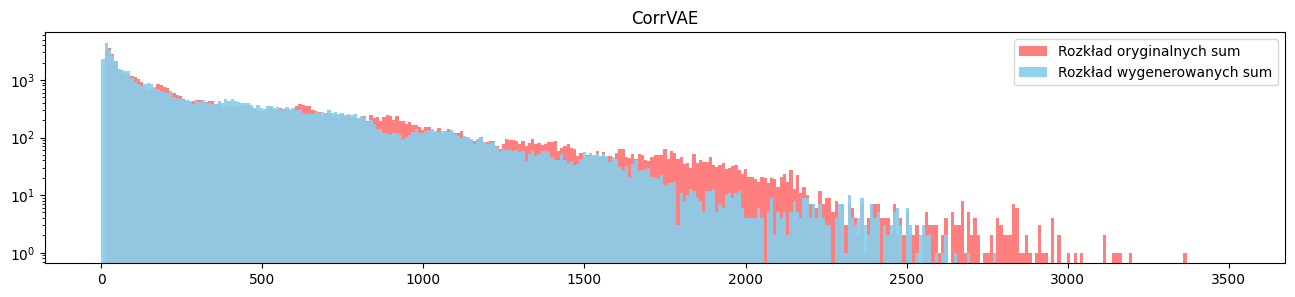

In [ ]:
import matplotlib.pyplot as plt


results_1_ = np.sum(results_1.reshape([-1, 44, 44]), axis=(1, 2)).flatten()
org_1_ = np.sum((np.exp(X_test.numpy())-1).reshape([-1, 44, 44]), axis=(1, 2)).flatten()

bins = np.linspace(0, 3500, 350)

# results = results*scale

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_1_, bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CorrVAE')
plt.show()


In [ ]:
results = torch.tensor(np.float32(np.log(results_1+1)))
mse_loss(results, X_test) / results.shape[0] / 64


tensor(1.0283)

In [ ]:
results_2 = calculate_ws_ch_corrvae(3, 1.20)


100%|██████████| 463/463 [00:56<00:00,  8.23it/s]


ws mean 3.83 ch1 3.99 ch2 3.65 ch3 3.19 ch4 2.88 ch5 5.46 

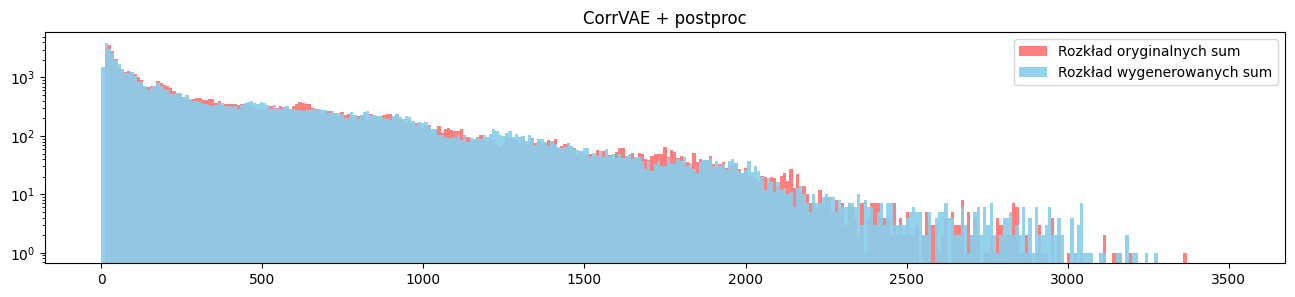

In [ ]:
results_2_ = np.sum(results_2.reshape([-1, 44, 44]), axis=(1, 2)).flatten() * 1.20

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_2_, bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CorrVAE + postproc')
plt.show()


In [ ]:
results = torch.tensor(np.float32(np.log(results_2+1)))
mse_loss(results*scale, X_test) / results.shape[0] / 64


tensor(1.1810)

In [ ]:
results_3 = calculate_ws_ch(vae_janek, 3, 1, 1)


1850/1850 [==============================] - 3s 2ms/step

 ------------------------------ 

ws mean 6.35 ch1 4.58 ch2 5.17 ch3 4.12 ch4 4.35 ch5 13.52 

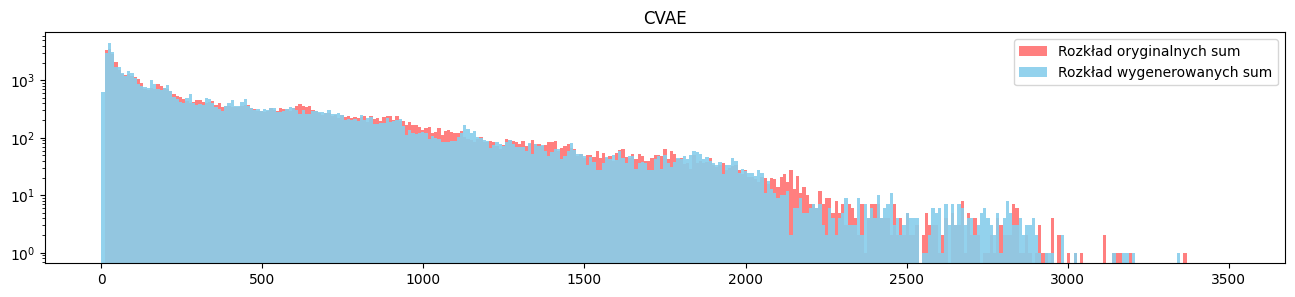

In [ ]:
results_3_ = np.sum(results_3.reshape([-1, 44, 44]), axis=(1, 2)).flatten()

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_3_ , bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CVAE')
plt.show()


In [ ]:
results = torch.tensor(np.float32(np.log(results_3+1)))
mse_loss(results.reshape(-1, 44, 44), X_test.reshape(-1, 44, 44)) / results.shape[0] / 64


tensor(1.0200)

In [ ]:
results_4 = calculate_ws_ch(gan_janek, 3, 1, 1)


1850/1850 [==============================] - 3s 2ms/step

 ------------------------------ 

ws mean 8.27 ch1 4.30 ch2 5.50 ch3 7.36 ch4 9.13 ch5 15.06 

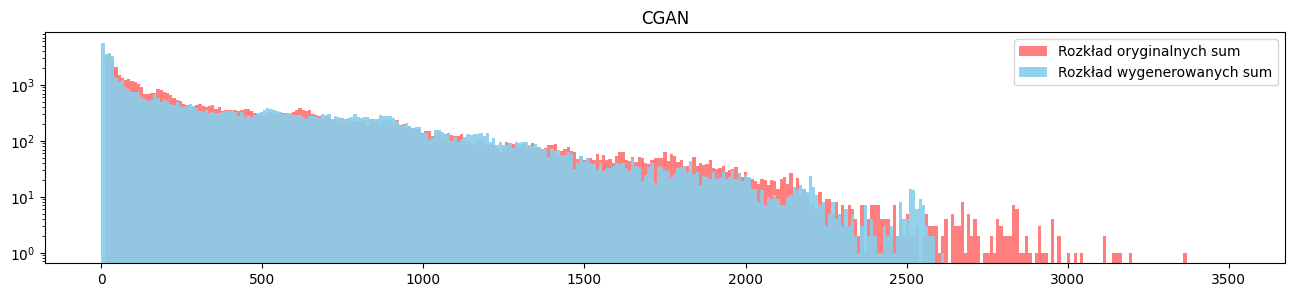

In [ ]:
results_4_ = np.sum(results_4.reshape([-1, 44, 44]), axis=(1, 2)).flatten()

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_4_ , bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CGAN')
plt.show()


In [ ]:
results = torch.tensor(np.float32(np.log(results_4+1)))
mse_loss(results.reshape(-1, 44, 44), X_test.reshape(-1, 44, 44)) / results.shape[0] / 64


tensor(2.9587)

In [ ]:
results_5 = calculate_ws_ch(gan_reg_janek, 3, 0.96, 3)


1850/1850 [==============================] - 3s 2ms/step

 ------------------------------ 

ws mean 5.15 ch1 2.67 ch2 5.57 ch3 4.12 ch4 5.70 ch5 7.70 

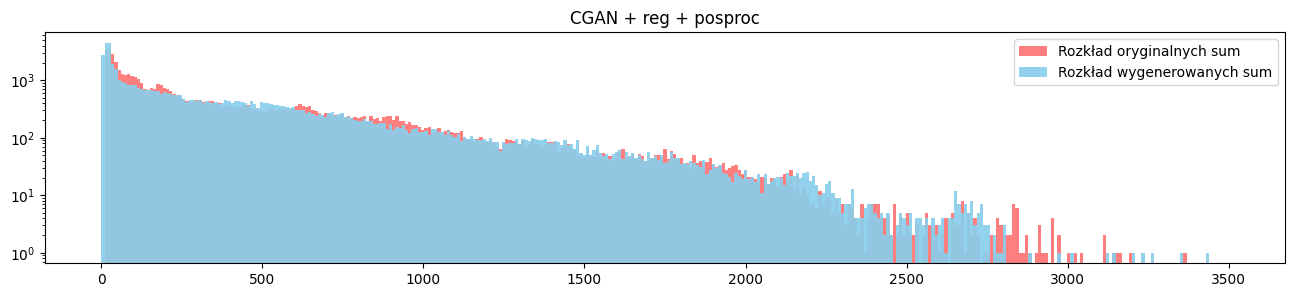

In [ ]:
results_5_ = np.sum(results_5.reshape([-1, 44, 44]), axis=(1, 2)).flatten()

plt.figure(figsize=(16,3))

plt.yscale('log')
plt.hist(org_1_, bins, alpha=.5, label='Rozkład oryginalnych sum', color='red')
plt.hist(results_5_ , bins, alpha=.9, label='Rozkład wygenerowanych sum', color='#87CEEB')

plt.legend()

plt.title('CGAN + reg + posproc')
plt.show()


In [ ]:
results = torch.tensor(np.float32(np.log(results_5+1)))
mse_loss(results.reshape(-1, 44, 44), X_test.reshape(-1, 44, 44)) / results.shape[0] / 64


tensor(2.9800)